# This jupyter notebook contains code for the results of cluster analysis applied to different depth ranges

In [1]:
## importing the dependencies
# importing necessary dependencies.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import obspy
import seaborn as sns
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import tsfel

import matplotlib.cm as cm
from matplotlib.colors import Normalize  
from matplotlib import ticker


from scipy.interpolate import griddata as gd
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

from cartopy.io.img_tiles import Stamen
import pygmt

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.dpi'] = 500

In [3]:
### Checking the folders present in the data directory
files = glob('Data/*')

file = glob('Data/*')[2]
vs = glob(file + '/*')

PO_HB = pd.read_csv(files[4], header = None, sep=' ')
X5 = pd.read_csv(files[5], header = None, sep=' ')

### storing station names and coordinates 
stations = []
for i in range(len(vs)):
    stations.append(vs[i].split('/')[2].split('_')[1])
    
stn_db = pd.concat([PO_HB,X5])
stn_db.index = stn_db[2]

stn_lons = []
stn_lats = []

for i in range(len(stations)):
    stn_lons.append(stn_db.at[stations[i],0])
    stn_lats.append(stn_db.at[stations[i],1])
    
features = []
vs_profiles = []
for i in tqdm(range(len(vs))):
    shear_velocity = pd.read_csv(vs[i], header=None, sep = ' ')[0]
    depth = pd.read_csv(vs[i], header=None, sep = ' ')[1]
    vs_profiles.append(shear_velocity.values)
    a  = shear_velocity.describe()
    features.append(a.values)
    
    
features = []
vs_profiles = []
for i in tqdm(range(len(vs))):
    shear_velocity = pd.read_csv(vs[i], header=None, sep = ' ')[0]
    vs_profiles.append(shear_velocity.values)
    a  = shear_velocity.describe()
    features.append(a.values)

100%|██████████| 59/59 [00:00<00:00, 497.84it/s]


In [18]:
### Importing and Plotting the fault lines

file = glob('Manuscript/Faults/Fault1*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault1_lons = fault1.values[:,0]
fault1_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault2*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault2_lons = fault1.values[:,0]
fault2_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault3*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault3_lons = fault1.values[:,0]
fault3_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault4*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault4_lons = fault1.values[:,0]
fault4_lats = fault1.values[:,1]

file = glob('Manuscript/Faults/Fault5*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault5_lons = fault1.values[:,0]
fault5_lats = fault1.values[:,1]


def plot_dendrogram(quantity=np.array(vs_profiles),method='ward', stn_labels=stations, d=[0,25]):

    X_primary = quantity[:,d[0]:d[1]]
    scaler = StandardScaler().fit(X_primary)
    X = scaler.transform(X_primary)
    df = df = pd.DataFrame(X,index=stn_labels)
    row_clusters = hierarchy.linkage(df.values,method=method,metric='euclidean')
    hierarchy.set_link_color_palette(['red','red','red','red'])
    plt.figure(figsize=[10,5], facecolor='white', dpi = 500)
    row_dendr = hierarchy.dendrogram(row_clusters,labels=stn_labels)
    #plt.title(, fontsize=15)
    plt.ylabel("Distance",fontsize=12)
    plt.xticks(fontsize=10)
    #plt.ylim(0,30)
    plt.tight_layout()
    
def cluster_profiles(quantity=np.array(vs_profiles), n_clusters=4, linkage='ward', d=[0,25], cluster='ac'):
    ### Applying pre-processing
    X_primary = quantity[:,d[0]:d[1]]
    scaler = StandardScaler().fit(X_primary)
    X = scaler.transform(X_primary)

    if cluster == 'ac':
        clustering = AgglomerativeClustering(n_clusters=n_clusters,affinity='euclidean',
                                         linkage=linkage, compute_distances=True).fit(np.array(X))
        label = clustering.labels_
        
    if cluster == 'kmm':
        clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
        label = clustering.labels_
        
    #label = clustering.labels_
    
    
    if cluster == 'gmm':
        label = GaussianMixture(n_components=n_clusters, random_state=0).fit_predict(X)
        
    return label

color = ['red', 'blue', 'green', 'orange','brown']
def plot_map(label, color=color, stn_lats = stn_lats, stn_lons=stn_lons, legend='legend1.txt'):
    
        ### PyGMT script
        region=[-105,-55, 50, 75]
        fig = pygmt.Figure()

        proj = 'S-80/90/6c'
        pygmt.makecpt(cmap='etopo1',series='-10000/10000/1000',continuous=True)

        #topo_data = '@earth_relief_01m'

        #fig.grdimage(grid=topo_data,region=region,projection='S-75/90/7i',cmap='geo',shading=True,frame='a')

        pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain",FONT_ANNOT_PRIMARY=7)

        fig.coast(area_thresh = 10000,
            projection=proj,
            region=region,
            shorelines=True,
            water="lightblue",
            resolution='i',
                 frame=["wsne"])

        fig.plot(x=fault1_lons,y=fault1_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault2_lons,y=fault2_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault3_lons,y=fault3_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault4_lons,y=fault4_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault5_lons,y=fault5_lats,style='c0.03c',color='black',pen='black',)
      



        for i in range(len(stn_lats)):
            fig.plot(
            x=stn_lons[i],
            y=stn_lats[i],
            style='c0.20c',
            color=color[int(label[i])],
            pen='black',
            )



        fig.text(projection='S-75/90/3i',
                text="0-50 Km, Clusters:2",
                position=[-80,75],
                font="12p,Helvetica-Bold,black",
                justify="TC",
            )

        #fig.text(text=stntexts,y=stnlats+0.01,x=stnlons+0.07,font="6p,Helvetica-Bold,blue")
        fig.legend(spec='Legends/'+legend,projection=proj, transparency=0, 
                   position = 'JTR+jTR+o-0.5c/-0.0c', 
                   box = '+gwhite+p1p')
        fig.show()
        return fig

# Upper Crust Analysis

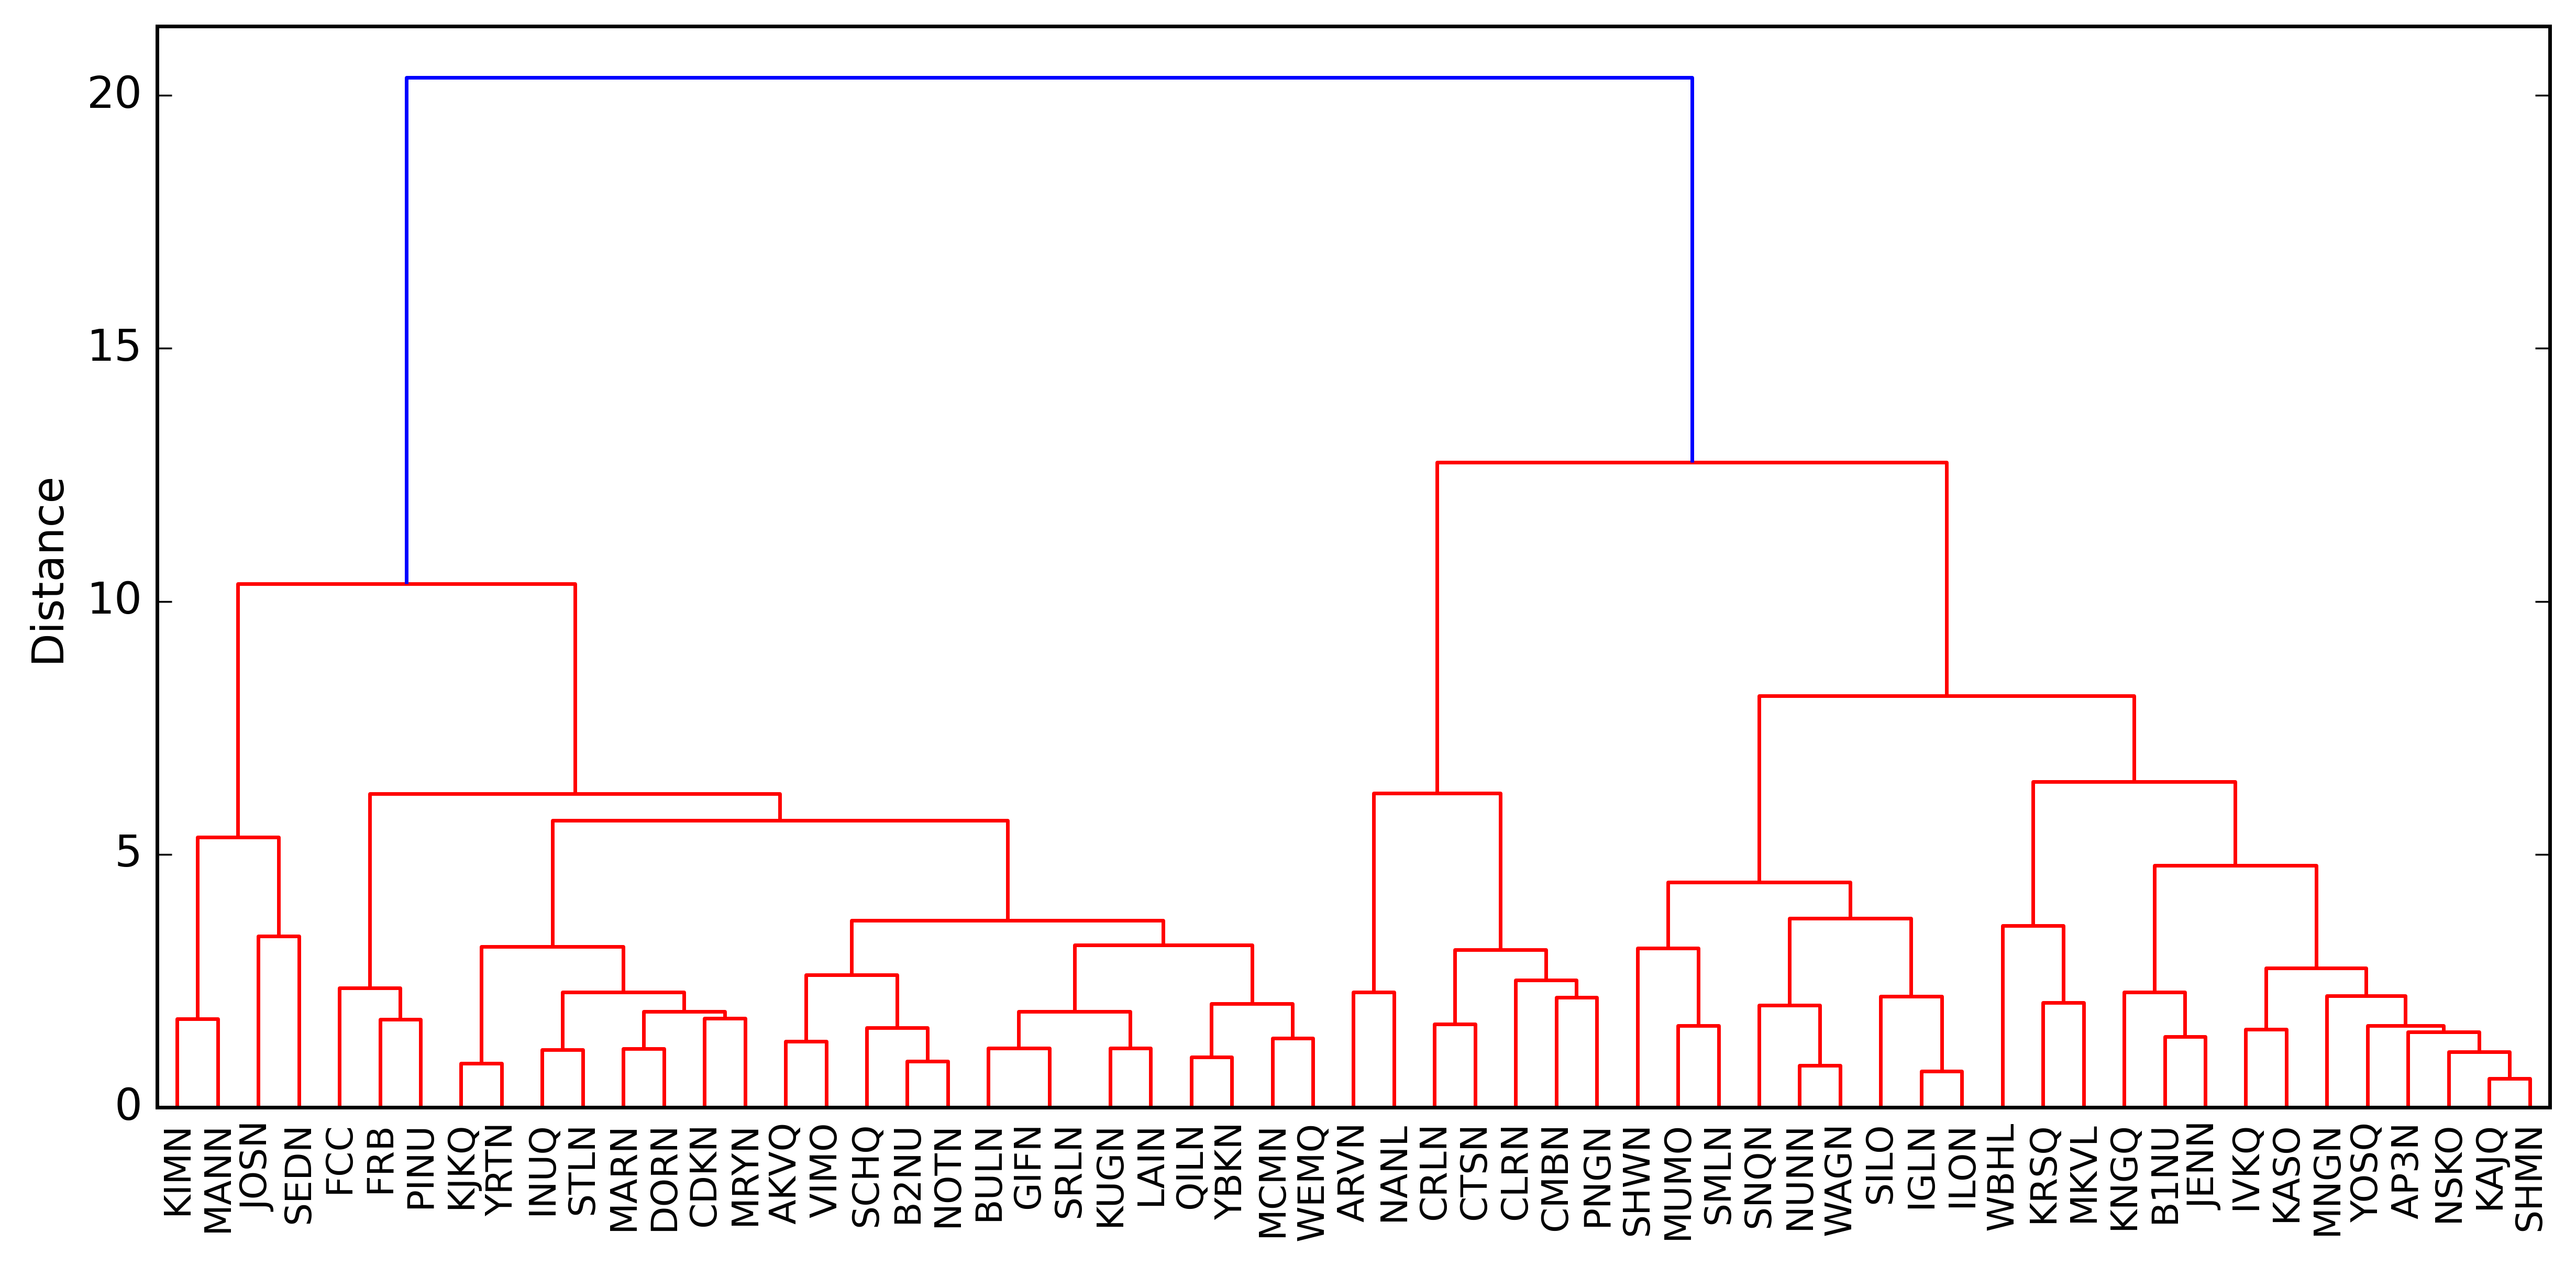

In [19]:
## upper crust
plot_dendrogram(quantity=np.array(vs_profiles),method='ward', stn_labels=stations, d=[0,10])

In [20]:
labels = cluster_profiles(quantity=np.array(vs_profiles), n_clusters=5, linkage='ward', d=[0,10], cluster='ac')

legend [WARNING]: Transparency is expected in percentage.  Did you mean 0?


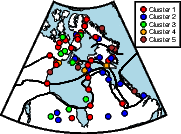

In [21]:
color = ['blue', 'red', 'brown', 'orange','green']
plot_map(labels, color=color, stn_lats = stn_lats, stn_lons=stn_lons, legend='legend5.txt')

In [22]:
l1 = np.array(vs_profiles)[labels == np.unique(labels)[1]]
l2 = np.array(vs_profiles)[labels == np.unique(labels)[0]]
l3 = np.array(vs_profiles)[labels == np.unique(labels)[4]]
l4 = np.array(vs_profiles)[labels == np.unique(labels)[3]]
l5 = np.array(vs_profiles)[labels == np.unique(labels)[2]]

[None, None, None, None]

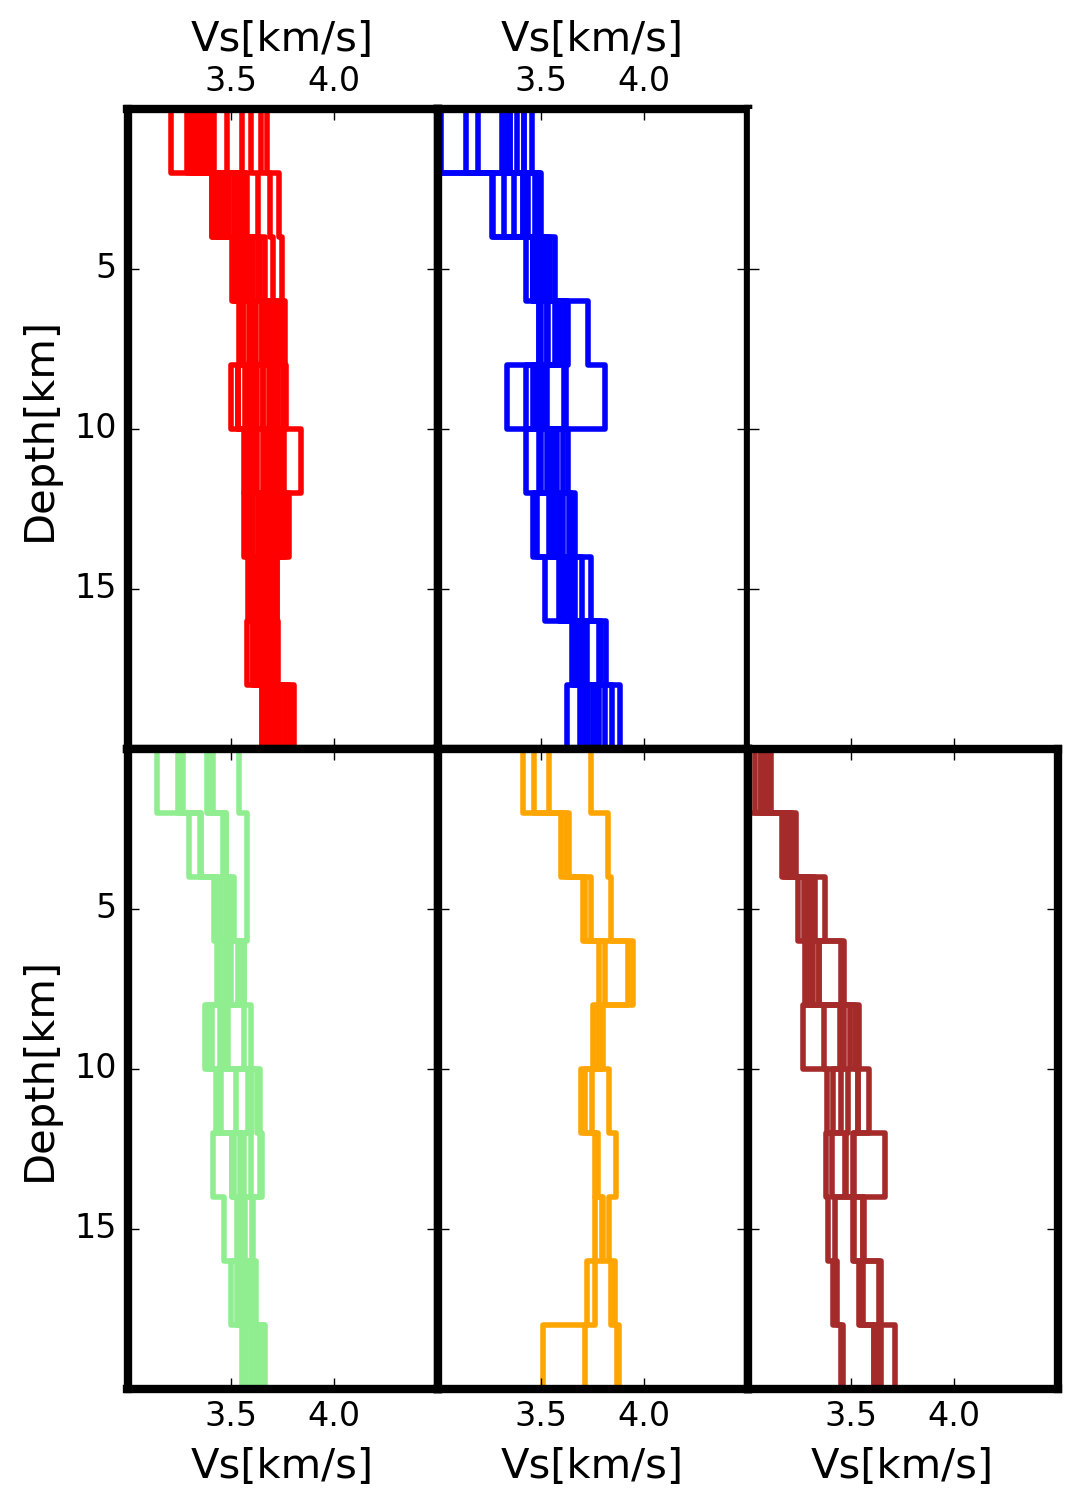

In [23]:
z = depth
plt.style.use('classic')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[6,8], sharex=True, sharey=True, facecolor= 'white', dpi = 200)
plt.subplots_adjust(hspace=.0, wspace=0)

#ax[0][0].axhline(np.around(np.mean(moho),1), lw=1, color='white')
for i in range(len(l1)):
    ax[0][0].step(x=l1[i],y=z,lw=2, color='red')
    ax[0][0].set_yticks([5, 10, 15])
    ax[0][0].xaxis.set_tick_params(labeltop=True)
    ax[0][0].xaxis.set_label_position('top') 
    ax[0][0].set_xlabel('Vs[km/s]', fontsize=15)
    ax[0][0].set_ylabel('Depth[km]',fontsize=15)
    

    
for i in range(len(l2)):
    ax[0][1].step(x=l2[i],y=z,lw=2, color='blue')
    ax[0][1].set_xticks([3.5, 4])
    ax[0][1].set_yticks([5, 10, 15])
    ax[0][1].xaxis.set_tick_params(labeltop=True)
    ax[0][1].xaxis.set_label_position('top') 
    ax[0][1].set_xlabel('Vs[km/s]', fontsize=15)
    
    ax[0][1].set_ylim(20,0)
    ax[0][1].set_xlim(3,4.5)
    #ax[0][2].set_ylabel('Depth[Km]',fontsize=15)
    
    
    
right_side = ax[0][2].spines["right"]
right_side.set_visible(False)

right_side = ax[0][2].spines["top"]
right_side.set_visible(False)

ax[0][2].tick_params(right=False)
ax[0][2].tick_params(top=False)



for i in range(len(l3)):
    ax[1][0].step(x=l3[i],y=z,lw=2, color='lightgreen')
    ax[1][0].set_ylim(20,0)
    ax[1][0].set_xlim(3,4.5)
    ax[1][0].set_ylabel('Depth[km]',fontsize=15)
    ax[1][0].set_xlabel('Vs[km/s]', fontsize=15)
   
    
    

for i in range(len(l4)):
    ax[1][1].step(x=l4[i],y=z,lw=2, color='orange')
    ax[1][1].set_ylim(20,0)
    ax[1][1].set_xticks([3.5, 4.])
    ax[1][1].set_xlim(3,5)
    ax[1][1].set_xlabel('Vs[km/s]', fontsize=15)
    #ax[1][1].set_ylabel('Depth[Km]',fontsize=15)
    

for i in range(len(l5)):
    ax[1][2].step(x=l5[i],y=z,lw=2, color="brown")
    ax[1][2].set_ylim(20,0)
    ax[1][2].set_xlim(3,4.5)
    ax[1][2].set_xlabel('Vs[km/s]', fontsize=15)
    #ax[1][2].set_ylabel('Depth[Km]',fontsize=15)
    
    
plt.setp(ax[0][0].spines.values(), linewidth=3)   
plt.setp(ax[0][1].spines.values(), linewidth=3) 
plt.setp(ax[1][0].spines.values(), linewidth=3) 
plt.setp(ax[1][1].spines.values(), linewidth=3) 
plt.setp(ax[1][2].spines.values(), linewidth=3)
#plt.tight_layout()

# Lower Crust

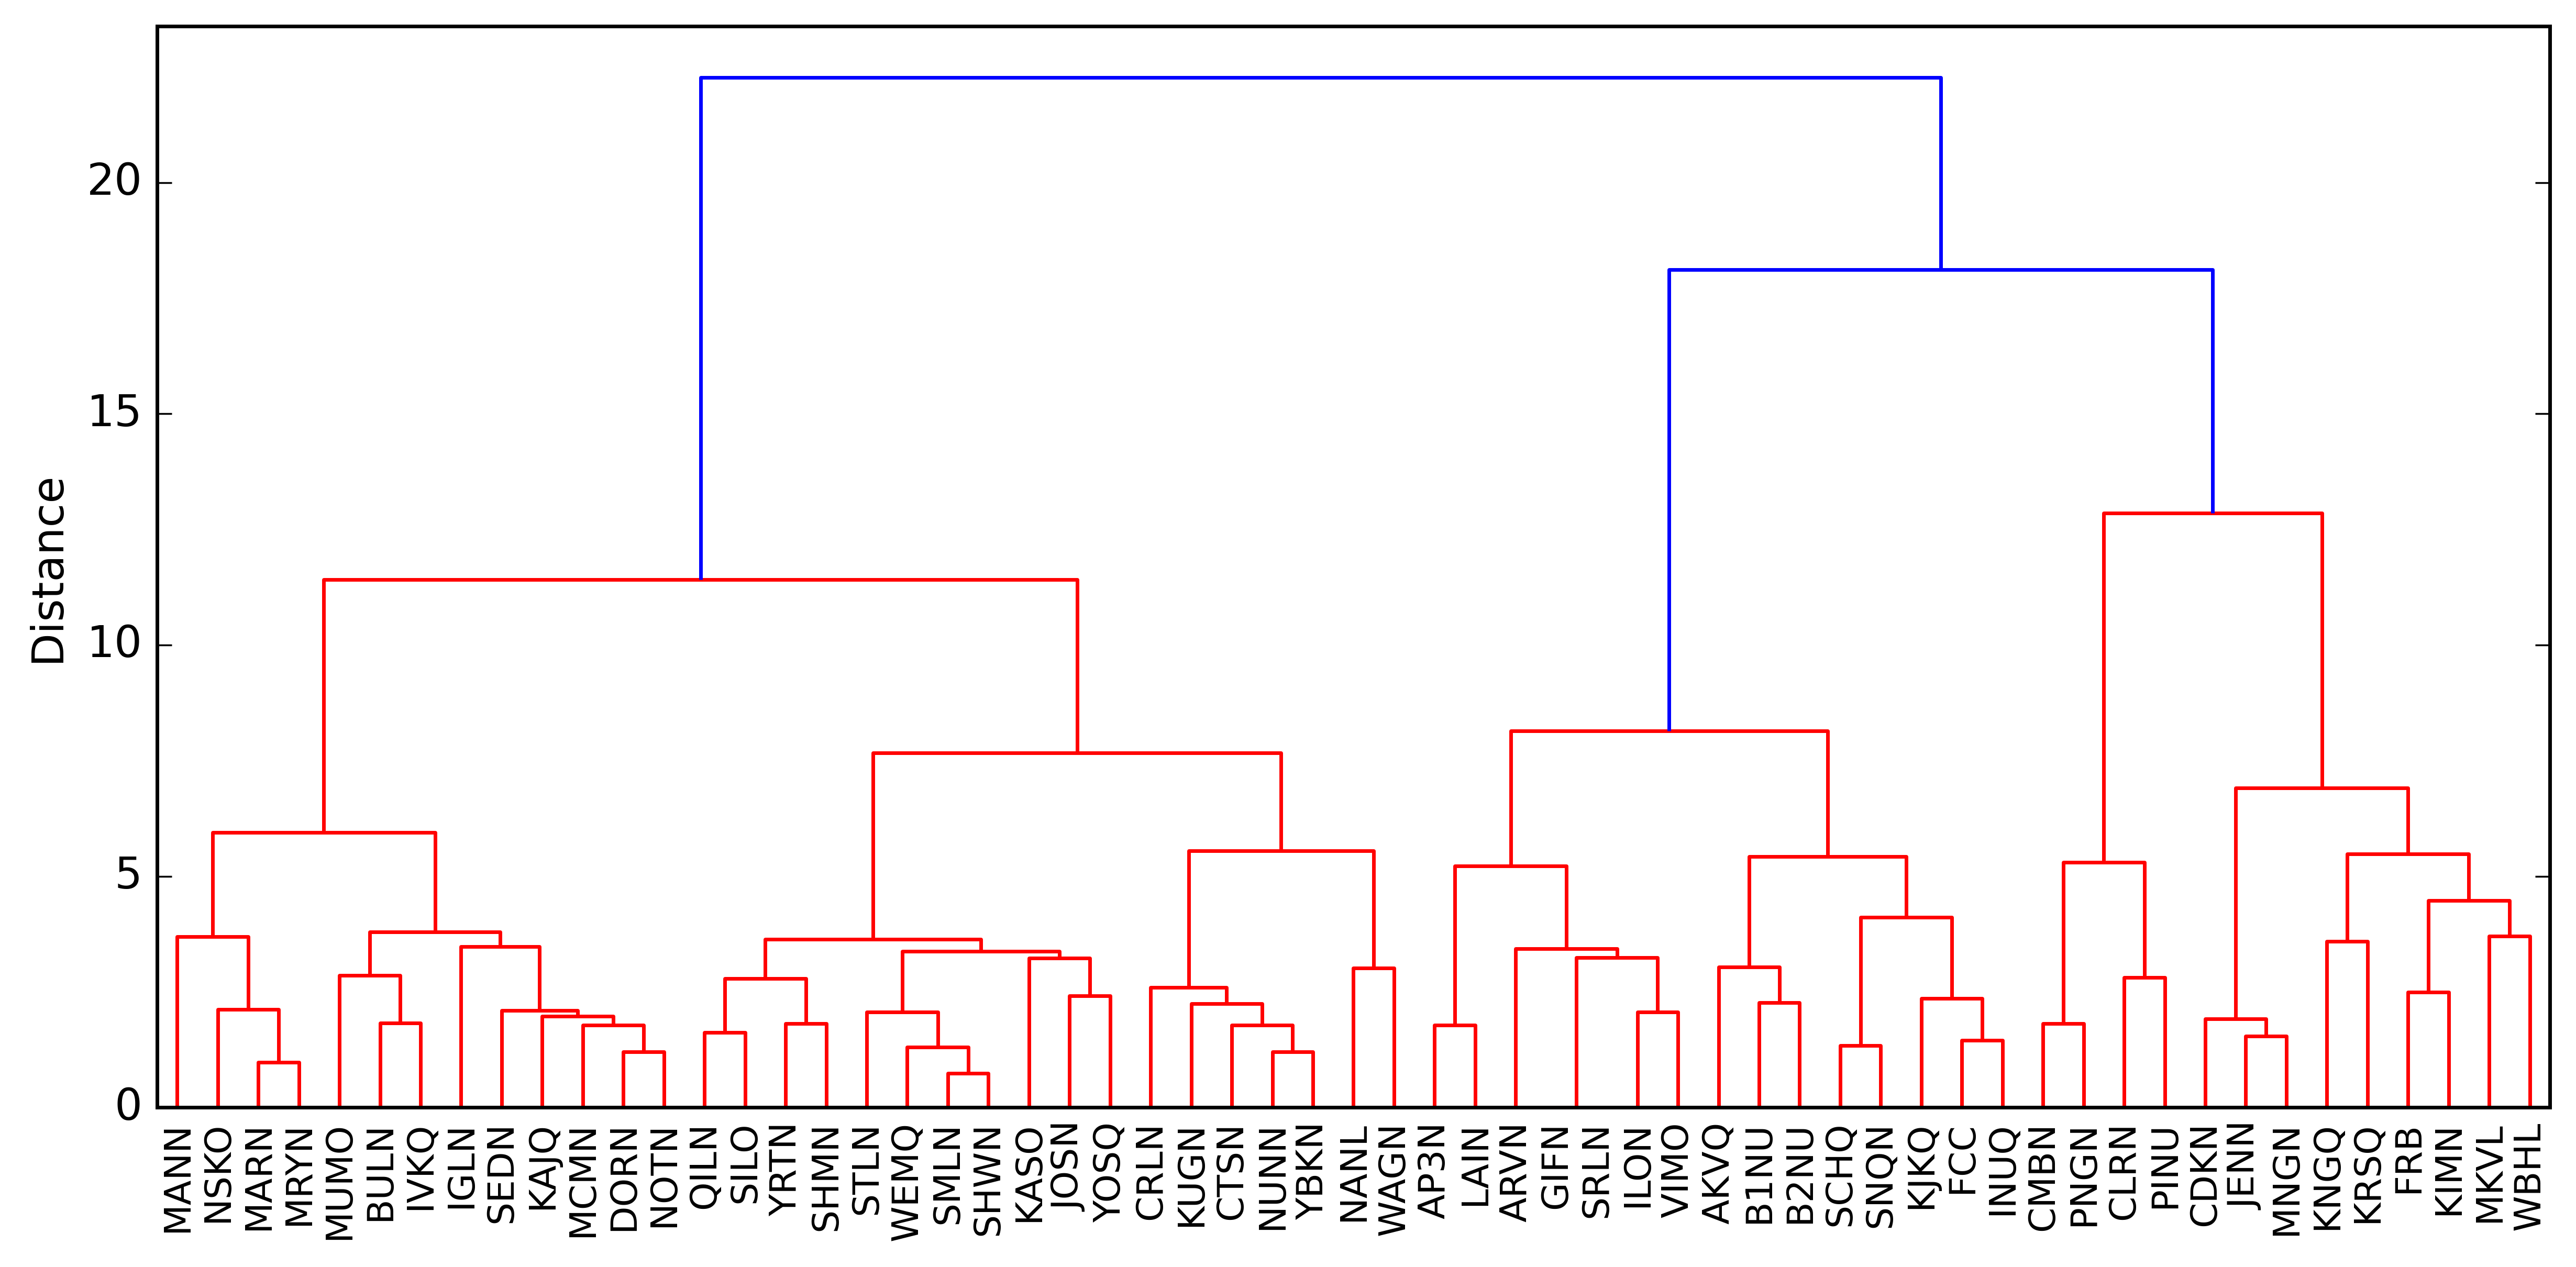

In [25]:
## lower crust
plot_dendrogram(quantity=np.array(vs_profiles),method='ward', stn_labels=stations, d=[10,25])

In [26]:
labels = cluster_profiles(quantity=np.array(vs_profiles), n_clusters=5, linkage='ward', d=[10,25], cluster='ac')

legend [WARNING]: Transparency is expected in percentage.  Did you mean 0?


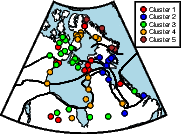

In [27]:
color = ['orange', 'blue', 'green', 'brown','red']
plot_map(labels, color=color, stn_lats = stn_lats, stn_lons=stn_lons, legend='legend5.txt')

In [28]:
l1 = np.array(vs_profiles)[labels == np.unique(labels)[4]]
l2 = np.array(vs_profiles)[labels == np.unique(labels)[1]]
l3 = np.array(vs_profiles)[labels == np.unique(labels)[2]]
l4 = np.array(vs_profiles)[labels == np.unique(labels)[0]]
l5 = np.array(vs_profiles)[labels == np.unique(labels)[3]]

[None, None, None, None]

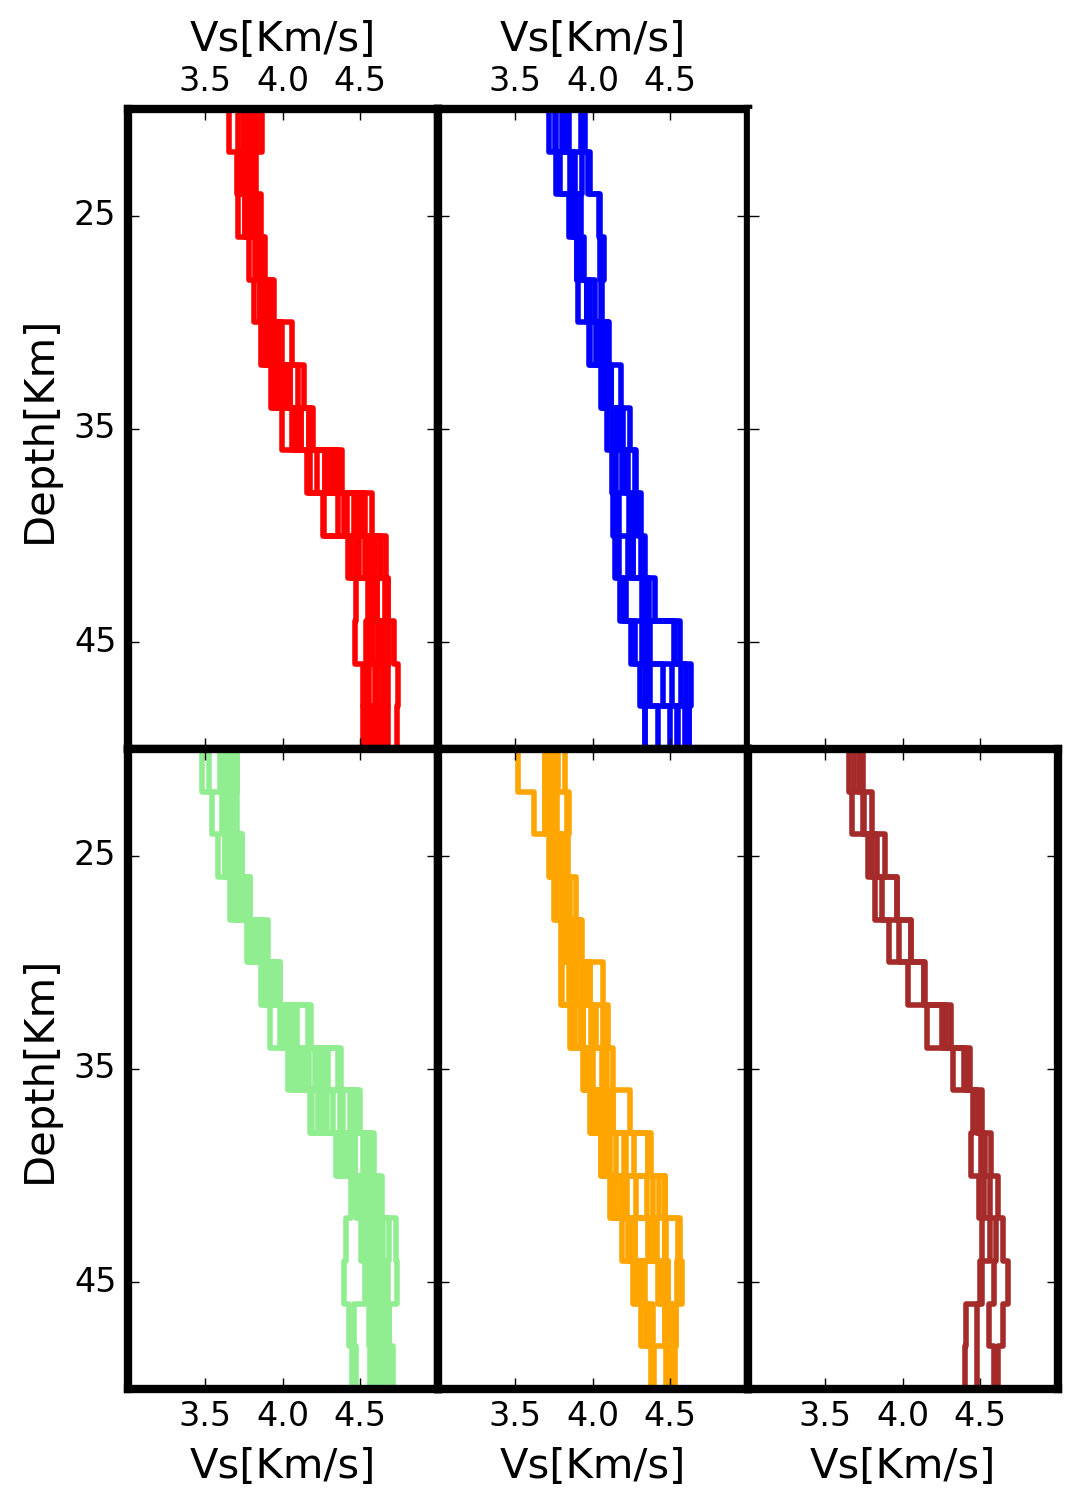

In [30]:
plt.style.use('classic')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[6,8], sharex=True, sharey=True, facecolor= 'white', dpi = 200)
plt.subplots_adjust(hspace=.0, wspace=0)

#ax[0][0].axhline(np.around(np.mean(moho),1), lw=1, color='white')
for i in range(len(l1)):
    ax[0][0].step(x=l1[i],y=z,lw=2, color='red')
    ax[0][0].set_yticks([ 10, 20, 30, 40])
    ax[0][0].xaxis.set_tick_params(labeltop=True)
    ax[0][0].xaxis.set_label_position('top') 
    ax[0][0].set_xlabel('Vs[Km/s]', fontsize=15)
    ax[0][0].set_ylabel('Depth[Km]',fontsize=15)
    

    
for i in range(len(l2)):
    ax[0][1].step(x=l2[i],y=z,lw=2, color='blue')
    ax[0][1].set_xticks([3.5, 4., 4.5])
    ax[0][1].set_yticks([25, 35, 45])
    ax[0][1].xaxis.set_tick_params(labeltop=True)
    ax[0][1].xaxis.set_label_position('top') 
    ax[0][1].set_xlabel('Vs[Km/s]', fontsize=15)
    
    ax[0][1].set_ylim(50,20)
    ax[0][1].set_xlim(3,5)
    #ax[0][2].set_ylabel('Depth[Km]',fontsize=15)
    
    
    
right_side = ax[0][2].spines["right"]
right_side.set_visible(False)

right_side = ax[0][2].spines["top"]
right_side.set_visible(False)

ax[0][2].tick_params(right=False)
ax[0][2].tick_params(top=False)



for i in range(len(l3)):
    ax[1][0].step(x=l3[i],y=z,lw=2, color='lightgreen')
    ax[1][0].set_ylim(20,0)
    ax[1][0].set_xlim(3,5)
    ax[1][0].set_ylabel('Depth[Km]',fontsize=15)
    ax[1][0].set_xlabel('Vs[Km/s]', fontsize=15)
   
    
    

for i in range(len(l4)):
    ax[1][1].step(x=l4[i],y=z,lw=2, color='orange')
    ax[1][1].set_ylim(20,0)
    ax[1][1].set_xticks([3.5, 4., 4.5])
    ax[1][1].set_xlim(3,5)
    ax[1][1].set_xlabel('Vs[Km/s]', fontsize=15)
    #ax[1][1].set_ylabel('Depth[Km]',fontsize=15)
    

for i in range(len(l5)):
    ax[1][2].step(x=l5[i],y=z,lw=2, color='brown')
    ax[1][2].set_ylim(50,20)
    ax[1][2].set_xlim(3,5)
    ax[1][2].set_xlabel('Vs[Km/s]', fontsize=15)
    #ax[1][2].set_ylabel('Depth[Km]',fontsize=15)
    
    
plt.setp(ax[0][0].spines.values(), linewidth=3)   
plt.setp(ax[0][1].spines.values(), linewidth=3) 
plt.setp(ax[1][0].spines.values(), linewidth=3) 
plt.setp(ax[1][1].spines.values(), linewidth=3) 
plt.setp(ax[1][2].spines.values(), linewidth=3)
#plt.tight_layout()

# Whole Crust

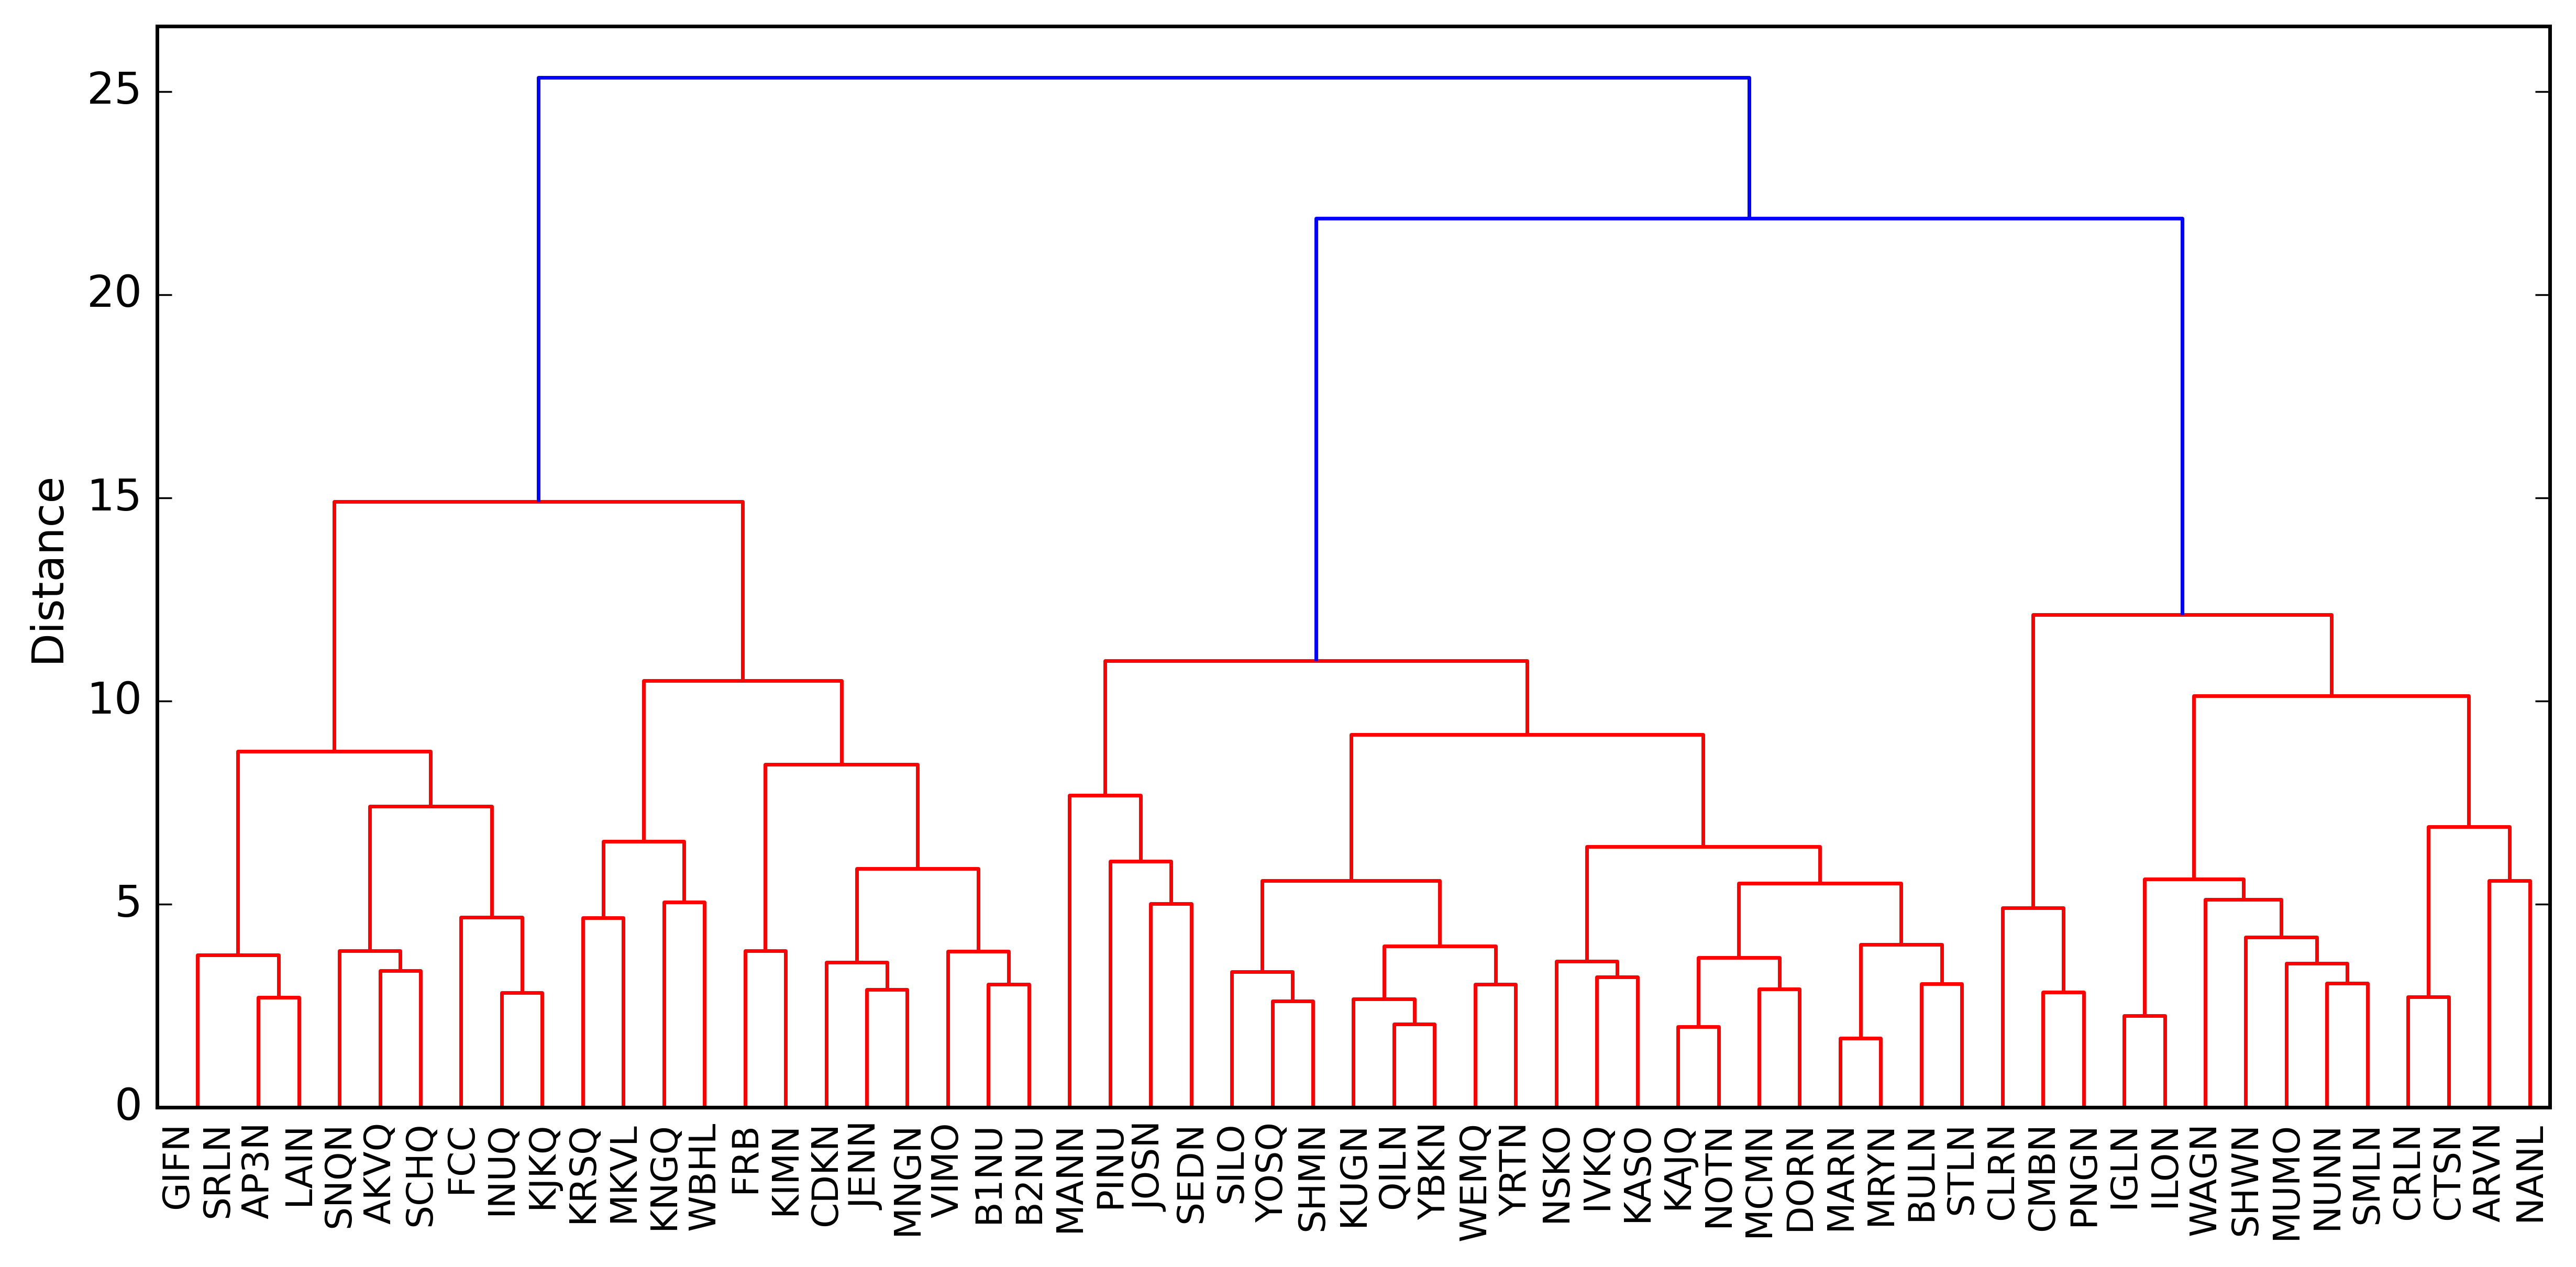

In [31]:
## whole crust
plot_dendrogram(quantity=np.array(vs_profiles),method='ward', stn_labels=stations, d=[0,25])

In [32]:
labels = cluster_profiles(quantity=np.array(vs_profiles), n_clusters=5, linkage='ward', d=[0,25], cluster='ac')

legend [WARNING]: Transparency is expected in percentage.  Did you mean 0?


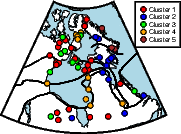

In [33]:
color = ['red', 'blue', 'green', 'orange','brown']
plot_map(labels, color=color, stn_lats = stn_lats, stn_lons=stn_lons, legend='legend5.txt')

In [34]:
l1 = np.array(vs_profiles)[labels == np.unique(labels)[0]]
l2 = np.array(vs_profiles)[labels == np.unique(labels)[1]]
l3 = np.array(vs_profiles)[labels == np.unique(labels)[2]]
l4 = np.array(vs_profiles)[labels == np.unique(labels)[3]]
l5 = np.array(vs_profiles)[labels == np.unique(labels)[4]]

[None, None, None, None]

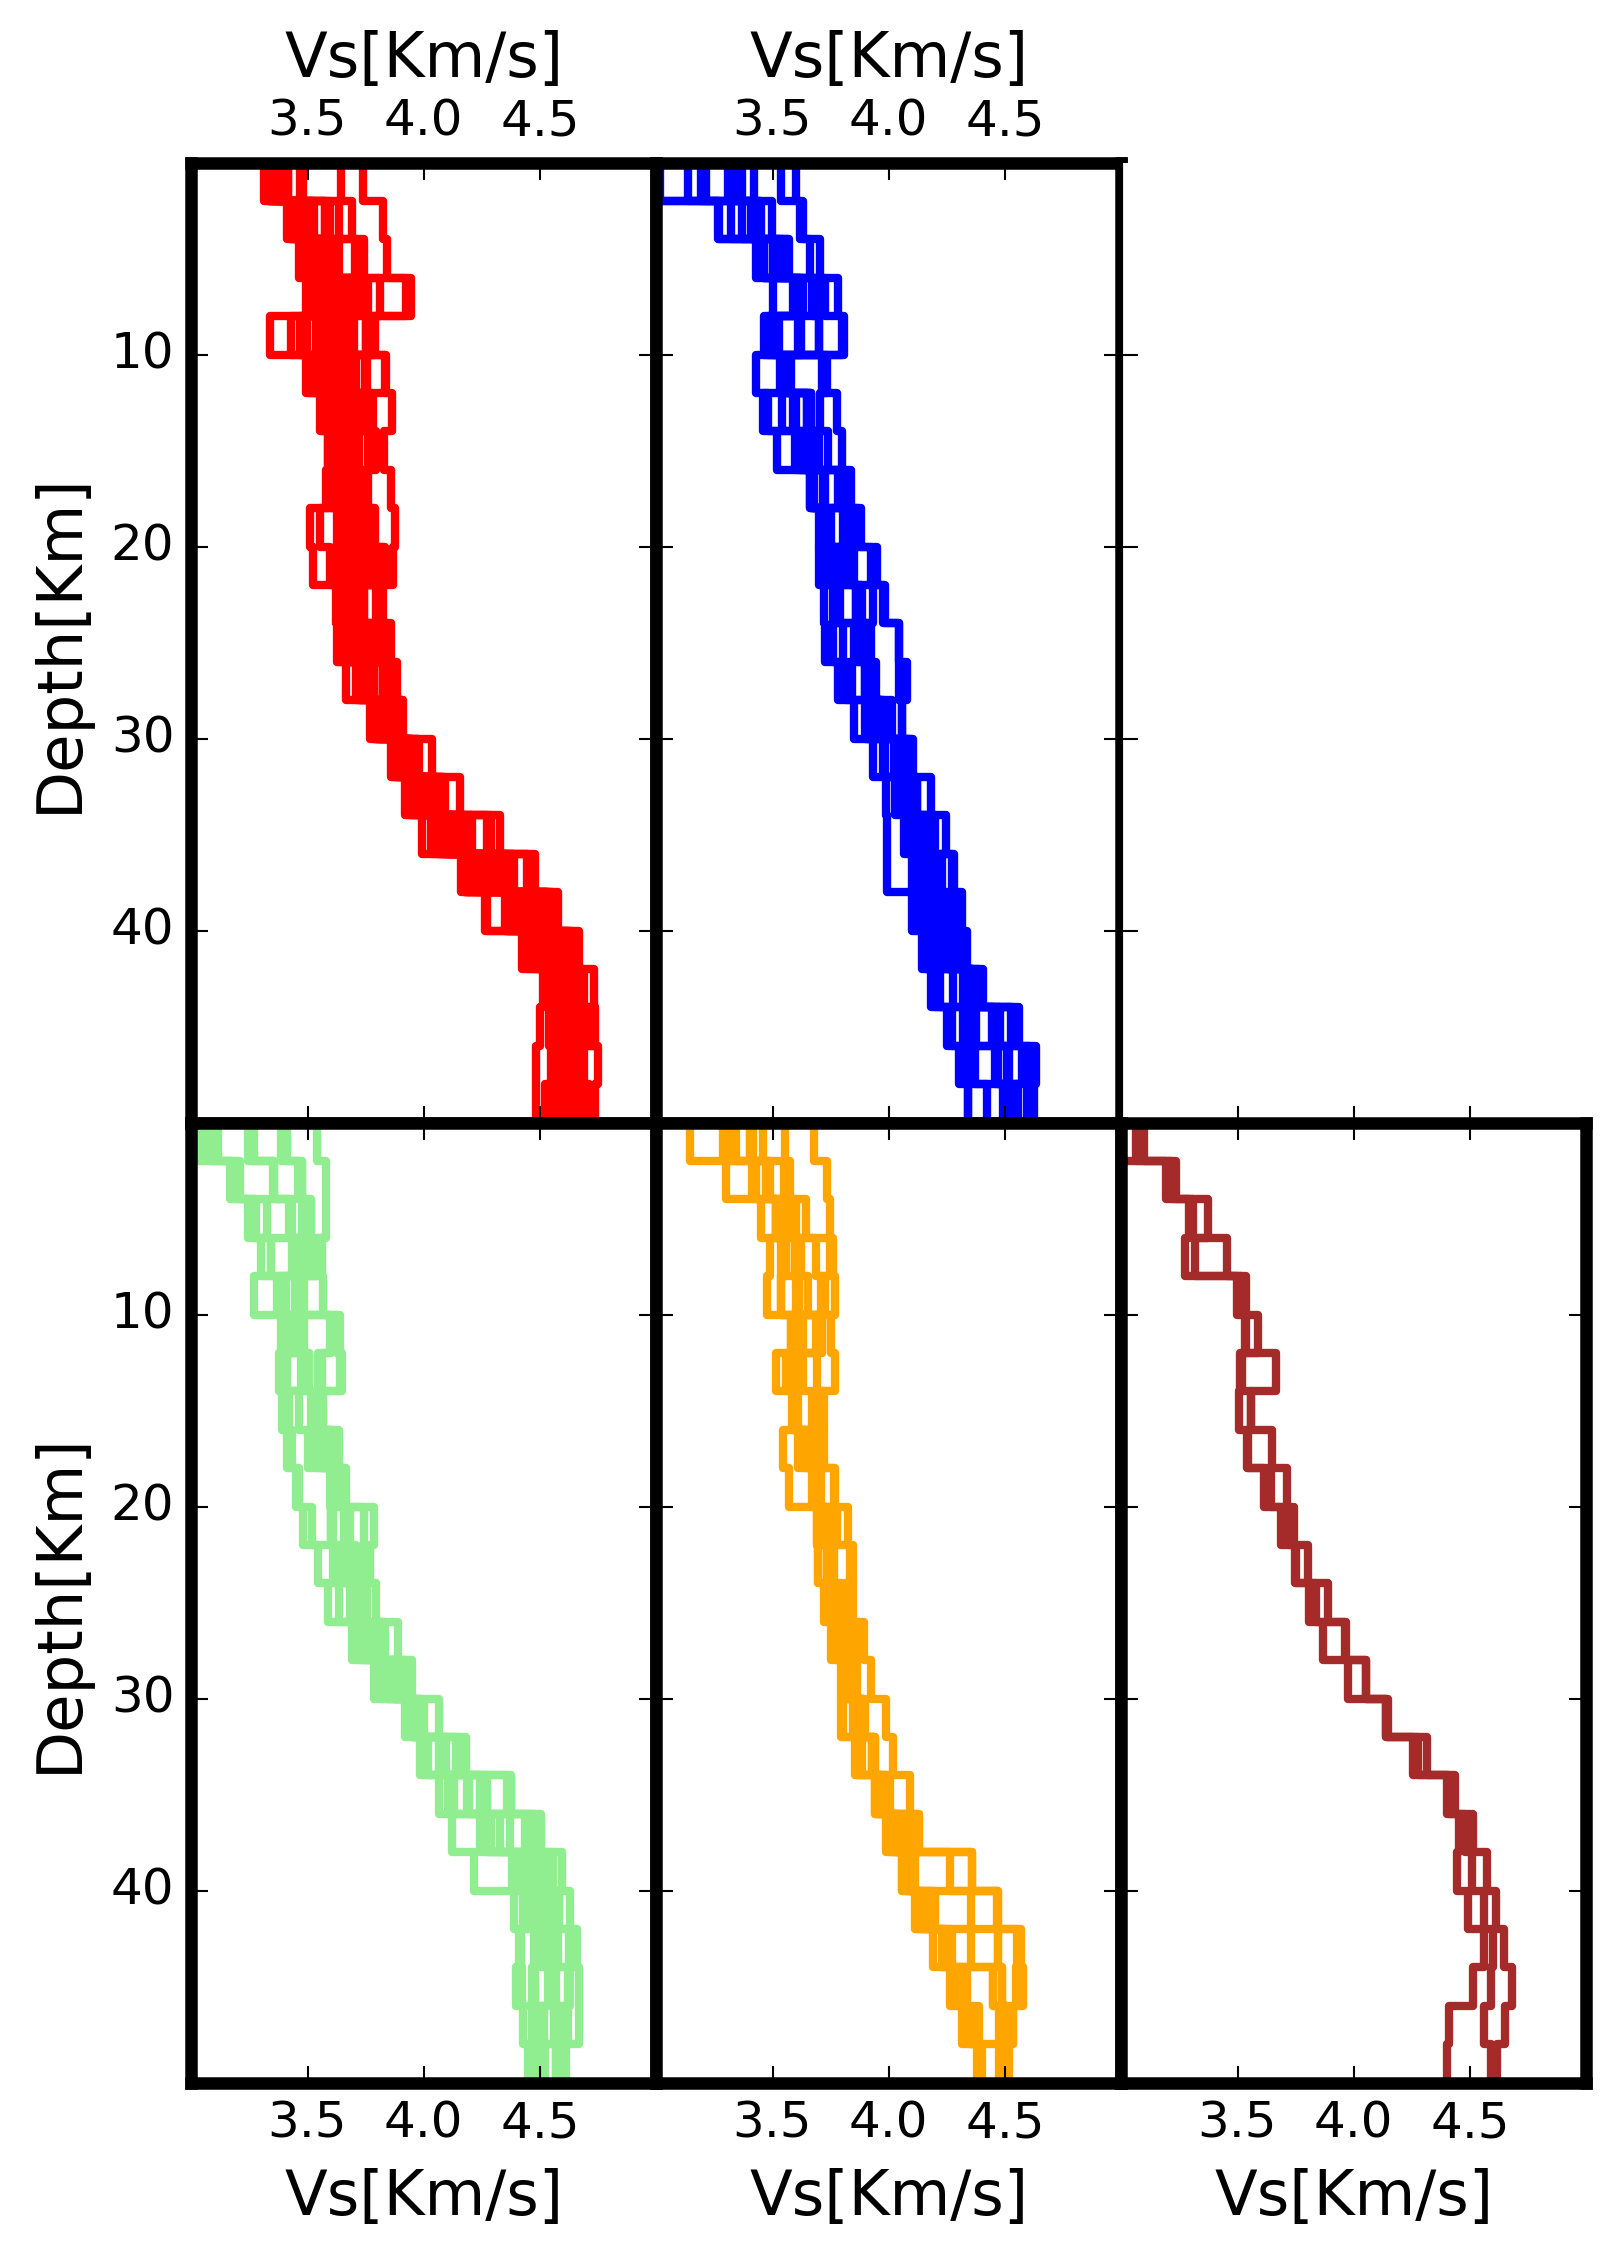

In [35]:
plt.style.use('classic')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[6,8], sharex=True, sharey=True, facecolor= 'white', dpi = 300)
plt.subplots_adjust(hspace=.0, wspace=0)

#ax[0][0].axhline(np.around(np.mean(moho),1), lw=1, color='white')
for i in range(len(l1)):
    ax[0][0].step(x=l1[i],y=z,lw=2, color='red')
    ax[0][0].set_yticks([ 10, 20, 30, 40])
    ax[0][0].xaxis.set_tick_params(labeltop=True)
    ax[0][0].xaxis.set_label_position('top') 
    ax[0][0].set_xlabel('Vs[Km/s]', fontsize=15)
    ax[0][0].set_ylabel('Depth[Km]',fontsize=15)
    

    
for i in range(len(l2)):
    ax[0][1].step(x=l2[i],y=z,lw=2, color='blue')
    ax[0][1].set_xticks([ 3.5, 4., 4.5])
    ax[0][1].set_yticks([10, 20, 30, 40])
    ax[0][1].xaxis.set_tick_params(labeltop=True)
    ax[0][1].xaxis.set_label_position('top') 
    ax[0][1].set_xlabel('Vs[Km/s]', fontsize=15)
    
    ax[0][1].set_ylim(50,0)
    ax[0][1].set_xlim(3,5)
    #ax[0][2].set_ylabel('Depth[Km]',fontsize=15)
    
    
    
right_side = ax[0][2].spines["right"]
right_side.set_visible(False)

right_side = ax[0][2].spines["top"]
right_side.set_visible(False)

ax[0][2].tick_params(right=False)
ax[0][2].tick_params(top=False)



for i in range(len(l3)):
    ax[1][0].step(x=l3[i],y=z,lw=2, color='lightgreen')
    ax[1][0].set_ylim(20,0)
    ax[1][0].set_xlim(3,5)
    ax[1][0].set_ylabel('Depth[Km]',fontsize=15)
    ax[1][0].set_xlabel('Vs[Km/s]', fontsize=15)
   
    
    

for i in range(len(l4)):
    ax[1][1].step(x=l4[i],y=z,lw=2, color='orange')
    ax[1][1].set_ylim(20,0)
    ax[1][1].set_xticks([ 3.5, 4., 4.5])
    ax[1][1].set_xlim(3,5)
    ax[1][1].set_xlabel('Vs[Km/s]', fontsize=15)
    #ax[1][1].set_ylabel('Depth[Km]',fontsize=15)
    

for i in range(len(l5)):
    ax[1][2].step(x=l5[i],y=z,lw=2, color='brown')
    ax[1][2].set_ylim(50,0)
    ax[1][2].set_xlim(3,5)
    ax[1][2].set_xlabel('Vs[Km/s]', fontsize=15)
    #ax[1][2].set_ylabel('Depth[Km]',fontsize=15)
    
    
plt.setp(ax[0][0].spines.values(), linewidth=3)   
plt.setp(ax[0][1].spines.values(), linewidth=3) 
plt.setp(ax[1][0].spines.values(), linewidth=3) 
plt.setp(ax[1][1].spines.values(), linewidth=3) 
plt.setp(ax[1][2].spines.values(), linewidth=3)
#plt.tight_layout()